In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wrangle
import prepare_ravinder
from sklearn.model_selection import train_test_split
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
sns.set()
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTENC

# Load Data

In [2]:
df = pd.read_csv('data/training_v2.csv')
id_col = 'encounter_id'

df1 = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
df_obj = df1[(df1['Data Type'] == 'string') | (df1['Data Type'] == 'binary')]
cat_features = list(df_obj['Variable Name'].values)
for c in cat_features:
    if c not in df1.columns or c == 'hospital_death':
        cat_features.remove(c)
print(f'cat_features: {cat_features}')

cat_features: ['bmi', 'ethnicity', 'hospital_admit_source', 'icu_admit_type', 'icu_type', 'apache_2_diagnosis', 'apache_post_operative', 'gcs_unable_apache', 'ventilated_apache', 'cirrhosis', 'hepatic_failure', 'leukemia', 'solid_tumor_with_metastasis', 'apache_2_bodysystem']


In [3]:
df3 = pd.read_csv('data/training_v2.csv')



In [4]:
df3.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,1

In [5]:
df3[['apache_2_diagnosis','apache_3j_diagnosis', 'apache_3j_bodysystem', 'apache_2_bodysystem']].head(2)

,apache_2_diagnosis,apache_3j_diagnosis,apache_3j_bodysystem,apache_2_bodysystem
0,113.0,502.01,Sepsis,Cardiovascular
1,108.0,203.01,Respiratory,Respiratory


In [6]:
df.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,1

In [7]:
df['gcs'] = df.gcs_eyes_apache + df.gcs_motor_apache + df.gcs_verbal_apache

In [8]:
df.shape

(91713, 187)

In [9]:
df1.head(2)

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient unit stay,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None


In [10]:
df['bool_'+ 'h1_lactate_max'] = np.where(pd.notnull(df['h1_lactate_max']), 1,0)

# Drop non_useful features

In [11]:
# columns missing a lot of data. We we instead create a boolean column which will indicate if the data is missing or not

missing = ['h1_bilirubin_max', 'h1_lactate_max',
       'h1_lactate_min', 'h1_albumin_max',
       'h1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max', 'h1_arterial_ph_max',
       'h1_arterial_ph_min', 'h1_hco3_max',
       'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_wbc_max',
       'h1_arterial_po2_min', 'h1_arterial_po2_max',
       'h1_calcium_max', 'h1_calcium_min', 
       'h1_platelets_max', 'h1_bun_max', 'h1_creatinine_max',
       'h1_hematocrit_min', 'h1_hematocrit_max',
       'h1_hemaglobin_min', 'h1_hemaglobin_max', 'h1_sodium_max',
       'h1_sodium_min', 'h1_potassium_min', 'h1_potassium_max']

In [12]:
to_remove=['hospital_id','icu_id','patient_id','encounter_id','apache_4a_hospital_death_prob','apache_4a_icu_death_prob' ] + missing


In [13]:
# df_n = df[df.apache_2_diagnosis.notnull()]
# df_n.head(2)

In [14]:
diagnosis = df.apache_2_diagnosis.value_counts().index
diagnosis = diagnosis.astype(str)

In [15]:
apache = [
 'age',
 'bmi',
 'height',
 'weight',
 'albumin_apache',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
 ]

In [16]:
# create a empty dataframe (with NaNs)
df_ = pd.DataFrame(index=apache, columns= diagnosis)
df_.head(2)

,113.0,301.0,302.0,112.0,308.0,117.0,124.0,122.0,303.0,110.0,304.0,203.0,202.0,106.0,305.0,114.0,121.0,123.0,102.0,307.0,119.0,120.0,118.0,108.0,214.0,109.0,105.0,213.0,207.0,306.0,218.0,217.0,209.0,219.0,101.0,104.0,103.0,115.0,116.0,107.0,215.0,208.0,212.0,216.0
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
for d in diagnosis:
    for a in apache:
        df_[d][a] = df[df.apache_2_diagnosis == float(d)][a].mean()

In [18]:
for a in apache:
    for d in diagnosis:
        df['diff_'+ a] = np.where(df[a].notnull(), df_[d][a]-df[a], 0)

In [19]:
df.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,...,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gcs,bool_h1_lactate_max,diff_age,diff_bmi,diff_height,diff_weight,diff_albumin_apache,diff_arf_apache,diff_bilirubin_apache,diff_bun_apache,diff_creatinine_apache,diff_fio2_apache,diff_glucose_apache,diff_heart_rate_apache,diff_hematocrit_apache,diff_intubated_apache,diff_map_apache,diff_paco2_apache,diff_paco2_for_ph_apache,diff_pao2_apache,diff_ph_apache,diff_resprate_apache,diff_sodium_apache,diff_temp_apache,diff_urineoutput_apache,diff_ventilated_apache,diff_wbc_apache
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,...,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [20]:
features = [col for col in df.columns if col not in to_remove]

In [21]:
def drop_correlated_features(df):
    df1 = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
    df1 = df1[(df1['Data Type'] == 'string') | (df1['Data Type'] == 'binary')]
    cat_features = list(df1['Variable Name'].values)
    for c in cat_features:
        if c not in df1.columns or c == 'hospital_death':
            cat_features.remove(c)

    num_feature = [col for col in features if col not in cat_features and df[col].dtype != 'object']
    drop_columns=[]
    corr = df[num_feature].corr()



    columns = np.full((corr.shape[0],), True, dtype=bool)

    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >=0.99 :
                if columns[j] == True:
                    columns[j] = False
#                     print('col1: {} col2: {} - Correlation: {}'.format(df[num_feature].columns[i] , df[num_feature].columns[j], corr.iloc[i,j]))
            elif corr.iloc[i,j] <= -0.99:
                if columns[j] == True:
                    columns[j] = False

    drop_columns = df[num_feature].columns[columns == False].values
    return drop_columns

In [22]:
drop_columns = drop_correlated_features(df)

In [23]:
drop_columns

array(['paco2_for_ph_apache', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_mbp_noninvasive_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'h1_mbp_noninvasive_min', 'h1_sysbp_noninvasive_max',
       'd1_bilirubin_max', 'd1_creatinine_max', 'h1_inr_max',
       'h1_inr_min', 'diff_age', 'diff_height', 'diff_weight',
       'diff_albumin_apache', 'diff_arf_apache', 'diff_bilirubin_apache',
       'diff_bun_apache', 'diff_creatinine_apache', 'diff_fio2_apache',
       'diff_glucose_apache', 'diff_heart_rate_apache',
       'diff_hematocrit_apache', 'diff_intubated_apache',
       'diff_map_apache', 'diff_paco2_apache', 'diff_paco2_for_ph_apache',
       'diff_pao2_apache', 'diff_ph_apache', 'diff_resprate_apache',
       'diff_sodium_apache', 'diff_temp_apache',
       'diff_urineoutput_apache', 'diff_wbc_apache'], dtype=object)

In [24]:

features = [col for col in features if col not in drop_columns]

In [25]:
df = df[features]
inv_cols=[s for s in df.columns.tolist() if "invasive" in s]
df.drop(inv_cols,axis=1,inplace=True)

In [26]:
df['icu_type']=df['icu_type'].replace({'CTICU':'CCU-CTICU',
                                              'Cardiac ICU':'CCT-CTICU',
                                              'CTICU':'CCT-CTICU',
                                              'CSICU':'SICU'})

df['hospital_admit_source']= df['hospital_admit_source'].replace({
                                        'Other ICU':"ICU",'ICU to SDU':"SDU",
                                       'Step-Down Unit (SDU)':"SDU",
                                      'Acute Care/Floor':"Floor",
                                      'Other Hospital':"Other"})


binary=[col for col in df.columns if df[col].nunique() == 2 and df[col].dtypes !='object']
categorical = [col for col in df.columns if df[col].dtypes == 'object']
df['apache_3j_diagnosis']= df['apache_3j_diagnosis'].fillna(0).astype(np.int64)
df['apache_2_diagnosis']= df['apache_2_diagnosis'].fillna(0).astype(np.int64)
categorical.append('apache_2_diagnosis')
categorical.append('apache_3j_diagnosis')

In [27]:
for col in binary:
    df[col]= df[col]+1
    df[col].fillna(0,inplace=True)
    df[col]= df[col].astype(np.int8).astype('category')

In [28]:
df['gcs_unable_apache'] = df['gcs_unable_apache'].astype('Int64')
for b in binary:
    df[b] = df[b].astype('Int64')

In [29]:
df.shape

(91713, 128)

In [30]:
df.head(2)

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_min,h1_bilirubin_min,h1_bun_min,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_min,h1_platelets_min,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gcs,bool_h1_lactate_max,diff_bmi,diff_ventilated_apache
0,1,68.0,22.73,1,Caucasian,M,180.3,Floor,Floor,admit,CCT-CTICU,0.541667,0,73.9,2.3,113,502,1,1,0.4,31.0,2.51,NaN,3.0,6.0,1,4.0,168.0,118.0,27.4,1,40.0,NaN,NaN,NaN,36.0,134.0,39.3,NaN,1,14.1,68.0,37.0,119.0,72.0,89.0,46.0,34.0,10.0,100.0,74.0,131.0,73.0,39.9,37.2,68.0,63.0,119.0,108.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,31.0,30.0,8.5,7.4,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2,1,1,1,1,1,Sepsis,Cardiovascular,13.0,1,4.411262,0.230769
1,1,77.0,27.42,1,Caucasian,F,160.0,Floor,Floor,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108,203,1,1,NaN,9.0,0.56,1.0,1.0,3.0,1,1.0,145.0,120.0,36.9,1,46.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,2,12.7,95.0,31.0,118.0,72.0,120.0,38.0,32.0,12.0,100.0,70.0,159.0,67.0,36.3,35.1,61.0,48.0,114.0,100.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,36.3,36.3,1.6,1.6,0.5,11.0,9.0,8.6,8.0,0.56,145.0,128.0,27.0,26.0,11.3,11.1,36.9,36.1,1.3,1.3,3.5,3.5,557.0,487.0,4.2,3.8,145.0,145.0,23.3,12.7,NaN,NaN,9.0,0.56,145.0,143.0,27.0,557.0,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.0,1,1,2,1,1,1,1,1,Respiratory,Respiratory,5.0,2,-0.278738,-0.769231


In [31]:
numeric_col =[col for col in df.columns if  df[col].dtypes !='object' and col not in binary]

In [32]:
redundant_features = ['readmission_status', 'apache_2_bodysystem', 'apache_2_diagnosis', 'apache_3j_diagnosis']

In [33]:
df.drop(columns = redundant_features, inplace = True)

In [34]:
numeric_col.remove('readmission_status')
numeric_col.remove('apache_2_diagnosis')
numeric_col.remove('apache_3j_diagnosis')
categorical.remove('apache_2_bodysystem')
categorical.remove('icu_stay_type')
categorical.remove('apache_2_diagnosis')
categorical.remove('apache_3j_diagnosis')

In [35]:
categorical

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_type',
 'apache_3j_bodysystem']

In [36]:
binary

['hospital_death',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'bool_h1_lactate_max']

In [37]:
df.shape

(91713, 124)

In [38]:
train, test = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

# Exploration

In [196]:
h1_arterial = [s for s in df.columns.tolist() if "h1_arterial" in s]
d1_arterial = [s for s in df.columns.tolist() if "d1_arterial" in s]

In [197]:
h1_arterial

['h1_arterial_pco2_max',
 'h1_arterial_pco2_min',
 'h1_arterial_ph_max',
 'h1_arterial_ph_min',
 'h1_arterial_po2_max',
 'h1_arterial_po2_min']

In [184]:
train2.head(2)

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_bilirubin_max,h1_bun_max,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,gcs
59226,2,72.0,32.041330,1,Caucasian,F,154.9,SDU,Floor,admit,MICU,0.061111,76.88,2.0,1,1,2.4,26.0,1.64,NaN,4.0,6.0,1,4.0,107.0,99.0,27.9,1,45.0,NaN,NaN,NaN,13.0,135.0,36.6,NaN,1,22.81,95.0,13.0,150.0,77.0,101.0,22.0,40.0,12.0,100.0,38.0,161.0,48.0,36.7,35.8,51.0,39.0,94.0,92.0,59.0,47.0,19.0,16.0,98.0,96.0,85.0,72.0,NaN,NaN,2.0,2.0,2.4,26.0,26.0,7.1,7.1,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,2,Sepsis,14.0
81334,1,58.0,34.334291,1,Caucasian,M,190.5,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,0.032639,124.60,2.5,1,1,1.2,70.0,2.85,NaN,1.0,1.0,1,1.0,319.0,138.0,37.4,1,47.0,NaN,NaN,NaN,53.0,117.0,36.2,NaN,2,16.20,137.0,14.0,138.0,83.0,144.0,42.0,53.0,17.0,99.0,81.0,161.0,77.0,37.8,36.2,64.0,22.0,128.0,116.0,86.0,42.0,53.0,30.0,98.0,96.0,121.0,96.0,37.8,37.4,2.6,2.5,1.0,70.0,63.0,8.5,8.1,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.4,1.4,2.7,1.9,358.0,358.0,4.3,4.1,123.0,152.0,16.20,16.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2,1,1,1,1,1,Sepsis,3.0


In [199]:
df.d1_pao2fio2ratio_min.isnull().sum()

66008

In [201]:
df.ventilated_apache.isnull().sum()

0

## Imputation
Imputation was done based on the type of variable it was. Broadly, there are numerical and categorical variables.

### Numerical variables

In [39]:
numeric_df = train[numeric_col]
numeric_df_test = test[numeric_col]
numeric_df.head(3)

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_min,h1_bilirubin_min,h1_bun_min,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_min,h1_platelets_min,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,gcs,diff_bmi,diff_ventilated_apache
59226,72.0,32.041330,154.9,0.061111,76.88,2.0,2.4,26.0,1.64,NaN,4.0,6.0,4.0,107.0,99.0,27.9,45.0,NaN,NaN,NaN,13.0,135.0,36.60,NaN,22.81,95.0,13.0,150.0,77.0,101.0,22.0,40.0,12.0,100.0,38.0,161.0,48.0,36.70,35.80,51.0,39.0,94.0,92.0,59.0,47.0,19.0,16.0,98.0,96.0,85.0,72.0,NaN,NaN,2.0,2.0,2.4,26.0,26.0,7.1,7.1,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,-4.900068,0.230769
81334,58.0,34.334291,190.5,0.032639,124.60,2.5,1.2,70.0,2.85,NaN,1.0,1.0,1.0,319.0,138.0,37.4,47.0,NaN,NaN,NaN,53.0,117.0,36.20,NaN,16.20,137.0,14.0,138.0,83.0,144.0,42.0,53.0,17.0,99.0,81.0,161.0,77.0,37.80,36.20,64.0,22.0,128.0,116.0,86.0,42.0,53.0,30.0,98.0,96.0,121.0,96.0,37.80,37.40,2.6,2.5,1.0,70.0,63.0,8.5,8.1,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.4,1.4,2.7,1.9,358.0,358.0,4.3,4.1,123.0,152.0,16.20,16.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,-7.193029,-0.769231
67173,78.0,32.764004,165.0,2.527083,89.20,NaN,NaN,NaN,NaN,NaN,3.0,6.0,5.0,NaN,41.0,NaN,63.0,NaN,NaN,NaN,12.0,NaN,36.33,NaN,NaN,108.0,44.0,70.0,44.0,116.0,63.0,20.0,12.0,98.0,91.0,149.0,104.0,37.22,36.33,85.0,64.0,53.0,50.0,85.0,85.0,18.0,13.0,97.0,97.0,138.0,125.0,37.22,36.44,NaN,NaN,NaN,12.0,12.0,NaN,NaN,0.56,115.0,115.0,23.0,23.0,13.7,13.7,40.7,40.7,NaN,NaN,NaN,NaN,164.0,164.0,4.4,4.4,141.0,141.0,7.59,7.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,-5.622741,0.230769


In [40]:
binary_df = train[binary]
binary_df_test = test[binary]


binary_df.head(3)

,hospital_death,elective_surgery,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,bool_h1_lactate_max
59226,2,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1
81334,1,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1
67173,1,2,2,1,1,1,1,1,1,1,1,1,1,1,2,1


In [41]:
categorical_df = train[categorical]
categorical_df_test = test[categorical]


categorical_df.isnull().sum()

ethnicity                 1123
gender                      19
hospital_admit_source    17227
icu_admit_source            92
icu_type                     0
apache_3j_bodysystem      1346
dtype: int64

In [42]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

In [43]:
imp = IterativeImputer(max_iter=3, verbose=0)
imp.fit(numeric_df)
imputed_df = imp.transform(numeric_df)
imputed_df = pd.DataFrame(imputed_df, columns=numeric_df.columns, index = numeric_df.index)

In [44]:
impt = IterativeImputer(max_iter=3, verbose=0)
impt.fit(numeric_df_test)
imputed_df_test = impt.transform(numeric_df_test)
imputed_df_test = pd.DataFrame(imputed_df_test, columns=numeric_df_test.columns, index = numeric_df_test.index)

In [45]:
for col in categorical:
    categorical_df[col].fillna(categorical_df[col].mode()[0],inplace=True)

In [46]:
for col in categorical:
    categorical_df_test[col].fillna(categorical_df_test[col].mode()[0],inplace=True)

In [47]:
imputed_df.head(2)

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_min,h1_bilirubin_min,h1_bun_min,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_min,h1_platelets_min,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,gcs,diff_bmi,diff_ventilated_apache
59226,72.0,32.041330,154.9,0.061111,76.88,2.0,2.4,26.0,1.64,0.631375,4.0,6.0,4.0,107.0,99.0,27.9,45.0,39.043981,111.909918,7.332579,13.0,135.0,36.6,311.742685,22.81,95.0,13.0,150.0,77.0,101.0,22.0,40.0,12.0,100.0,38.0,161.0,48.0,36.7,35.8,51.0,39.0,94.0,92.0,59.0,47.0,19.0,16.0,98.0,96.0,85.0,72.0,36.281742,36.235268,2.0,2.0,2.4,26.0,26.0,7.1,7.1,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,2.086432,2.317737,24.674027,1.565968,124.840617,122.568706,21.406293,79.602327,23.040483,43.890523,35.451546,7.348125,7.298651,193.475212,101.805919,253.883217,213.807371,14.0,-4.900068,0.230769
81334,58.0,34.334291,190.5,0.032639,124.60,2.5,1.2,70.0,2.85,0.634495,1.0,1.0,1.0,319.0,138.0,37.4,47.0,55.484969,109.142448,7.374620,53.0,117.0,36.2,1010.744372,16.20,137.0,14.0,138.0,83.0,144.0,42.0,53.0,17.0,99.0,81.0,161.0,77.0,37.8,36.2,64.0,22.0,128.0,116.0,86.0,42.0,53.0,30.0,98.0,96.0,121.0,96.0,37.800000,37.400000,2.6,2.5,1.0,70.0,63.0,8.5,8.1,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.4,1.4,2.7,1.9,358.0,358.0,4.3,4.1,123.0,152.0,16.20,16.20,2.699082,1.051990,67.773397,2.711944,201.666964,212.909651,33.447531,358.760638,16.056691,58.978648,50.127130,7.390117,7.350893,57.338683,89.419545,198.156965,170.780434,3.0,-7.193029,-0.769231


In [48]:
imputed_df.shape, imputed_df_test.shape

((73370, 101), (18343, 101))

In [49]:
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(imputed_df)

imputed_df_scaled = pd.DataFrame(scaler.transform(imputed_df), columns=imputed_df.columns.values).set_index([imputed_df.index.values])



In [50]:
scaler1 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(imputed_df_test)

imputed_df_test_scaled = pd.DataFrame(scaler1.transform(imputed_df_test), columns=imputed_df_test.columns.values).set_index([imputed_df_test.index.values])


In [51]:
numeric_df.shape, categorical_df.shape, binary_df.shape

((73370, 101), (73370, 6), (73370, 16))

# Encoding

## Label encoding


In [53]:
categorical_df.dtypes

ethnicity                object
gender                   object
hospital_admit_source    object
icu_admit_source         object
icu_type                 object
apache_3j_bodysystem     object
dtype: object

In [54]:
categorical_df.apache_3j_bodysystem.value_counts()

Cardiovascular          25284
Neurological             9576
Sepsis                   9395
Respiratory              9283
Gastrointestinal         7220
Metabolic                6101
Trauma                   3084
Genitourinary            1740
Musculoskeletal/Skin      936
Hematological             503
Gynecological             248
Name: apache_3j_bodysystem, dtype: int64

## One hot encoding

In [55]:
from sklearn.preprocessing import OneHotEncoder

In [56]:
categorical_df.columns

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_type', 'apache_3j_bodysystem'],
      dtype='object')

In [57]:
binary_df.drop(columns=['hospital_death'], inplace = True)
binary_df_test.drop(columns=['hospital_death'], inplace = True)

In [58]:
l = ['ethnicity','gender','hospital_admit_source', 'icu_admit_source','icu_type', 'apache_3j_bodysystem',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [59]:
train1 = pd.concat([categorical_df, binary_df], axis =1)
test1 = pd.concat([categorical_df_test, binary_df_test], axis =1)

In [60]:
train1.head(2)

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_type,apache_3j_bodysystem,elective_surgery,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,bool_h1_lactate_max
59226,Caucasian,F,SDU,Floor,MICU,Sepsis,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1
81334,Caucasian,M,Direct Admit,Accident & Emergency,Med-Surg ICU,Sepsis,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1


In [61]:
train1 = prepare_ravinder.encode(train1, l)
test1 = prepare_ravinder.encode(test1, l)

In [62]:
numeric_df.shape, categorical_df.shape, binary_df.shape

((73370, 101), (73370, 6), (73370, 15))

In [63]:
imputed_df.shape, categorical_df.shape, binary_df.shape

((73370, 101), (73370, 6), (73370, 15))

In [64]:
train = pd.concat([imputed_df_scaled ,train1], axis =1)
test = pd.concat([imputed_df_test_scaled ,test1], axis =1)


train

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_min,h1_bilirubin_min,h1_bun_min,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_min,h1_platelets_min,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,gcs,diff_bmi,diff_ventilated_apache,bool_h1_lactate_max,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_F,gender_M,hospital_admit_source_Chest Pain Center,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_ICU,hospital_admit_source_Observation,hospital_admit_source_Operating Room,hospital_admit_source_Other,hospital_admit_source_PACU,hospital_admit_source_Recovery Room,hospital_admit_source_SDU,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_type_CCT-CTICU,icu_type_CCU-CTICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,elective_surgery_1,elective_surgery_2,apache_post_operative_1,apache_post_operative_2,arf_apache_0,arf_apache_1,arf_apache_2,gcs_unable_apache_0,gcs_unable_apache_1,gcs_unable_apache_2,intubated_apache_0,intubated_apache_1,intubated_apache_2,ventilated_apache_0,ventilated_apache_1,ventilated_apache_2,aids_0,aids_1,aids_2,cirrhosis_0,cirrhosis_1,cirrhosis_2,diabetes_mellitus_0,diabetes_mellitus_1,diabetes_mellitus_2,hepatic_failure_0,hepatic_failure_1,hepatic_failure_2,immunosuppression_0,immunosuppression_1,immunosuppression_2,leukemia_0,leukemia_1,leukemia_2,lymphoma_0,lymphoma_1,lymphoma_2,solid_tumor_with_metastasis_0,solid_tumor_with_metastasis_1,solid_tumor_with_metastasis_2
59226,0.370357,0.324644,0.158762,0.135887,0.259701,0.305987,0.057279,0.192477,0.121607,0.434122,1.000000,1.0,0.75,0.129516,0.466216,0.298455,0.191034,0.353255,0.325753,0.615340,0.092265,0.439024,0.600894,0.639797,0.492273,0.411765,0.000000,0.773109,0.440000,0.336127,0.000000,0.333333,0.120000,0.987523,0.38,0.500000,0.058824,0.633201,0.280236,0.150892,0.186813,0.406780,0.518519,0.167070,0.144718,0.168219,0.124031,0.944794,0.905706,0.091846,0.154348,0.250282,0.521136,0.235294,0.264706,0.053068,0.180328,0.208920,0.312334,0.369259,0.223976,0.109665,0.290196,0.337409,0.40625,0.673914,0.300926,0.745981,0.348083,0.349010,0.201523,0.390776,0.418319,0.096774,0.115884,0.309524,0.500

In [86]:
binary

['hospital_death',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'bool_h1_lactate_max']

In [84]:
train.columns.to_list()

['age',
 'bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'albumin_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'map_apache',
 'paco2_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'wbc_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_spo2_max',
 'h1_spo2_min',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'h1_temp_max',
 'h1_temp_min',
 'd1_albumin_max',
 'd1_albumin_min',
 'd1_bilirubin_min',
 'd1_bun_max',
 '

# Modeling

## Baseline

## Logist regression

### Building a Model

In [65]:
from sklearn.linear_model import LogisticRegression

In [66]:
# param = ['height',
#  'temp_apache',
#  'd1_diasbp_max',
#  'd1_diasbp_min',
#  'd1_heartrate_max',
#  'd1_heartrate_min',
#  'd1_mbp_max',
#  'd1_mbp_min',
#  'd1_spo2_max',
#  'd1_spo2_min',
#  'd1_sysbp_max',
#  'd1_sysbp_min',
#  'd1_temp_max',
#  'd1_temp_min']
# for p in param:  
#     complet_df['bool_'+ p] = np.where(pd.notnull(complet_df[p]), 1,0)

In [67]:
train2, test2 = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [68]:
y = train2[['hospital_death']]
y['hospital_death'] = y['hospital_death']-1
X = train

y_test = test2[['hospital_death']]
y_test['hospital_death'] = y_test['hospital_death']-1
X_test = test

In [69]:
y['hospital_death'] = y['hospital_death'].astype(int)
y_test['hospital_death'] = y_test['hospital_death'].astype(int)

In [70]:
X.shape, y.shape

((73370, 183), (73370, 1))

In [149]:
logit = LogisticRegression(C = 100, class_weight = 'balanced',penalty = 'l2', max_iter=1000)
logit.fit(X, y)

LogisticRegression(C=100, class_weight='balanced', max_iter=1000)

In [150]:
y_pred = logit.predict(X)

In [151]:
y_pred_test = logit.predict(X_test)

In [152]:
# X.columns

In [153]:
feature_imp = pd.DataFrame(logit.coef_[0], index = X.columns).reset_index()

In [154]:
feature_imp.columns = ['feature', 'coeff']
feature_imp.sort_values('coeff')

,feature,coeff
33,d1_spo2_max,-4.086746
84,h1_creatinine_min,-2.809262
115,hospital_admit_source_Observation,-2.690086
38,d1_temp_min,-2.613551
74,d1_platelets_min,-2.043931
...,...,...
56,d1_bun_max,2.299147
80,d1_wbc_min,2.309410
72,d1_lactate_min,3.858020
0,age,4.335190


In [155]:
# feature_imp.to_csv('data/feature_imp.csv')

### AUC Roc score

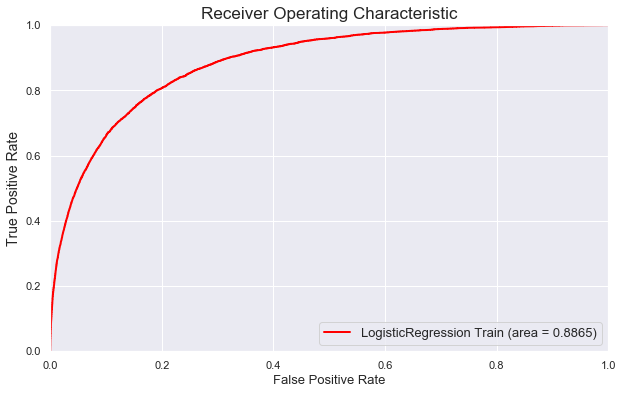

In [156]:
plt.figure(figsize=(10,6))

y_pred = logit.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

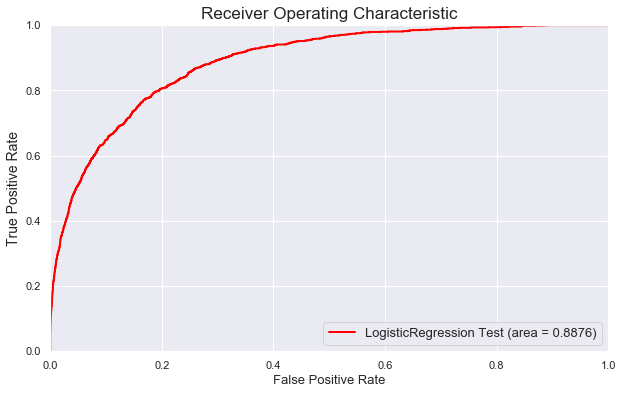

In [157]:
plt.figure(figsize=(10,6))

y_pred_test = logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
         


# y_pred = knn.predict_proba(X_validate_scaled)[:,1]
# fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
# plt.plot(fpr, tpr, color='yellow', lw=3, label='KNN (area = %0.2f)' % auc(fpr, tpr))


# y_pred_test = rf.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
# plt.plot(fpr, tpr, color='brown', lw=2, label='RandomForest (area = %0.2f)' % auc(fpr, tpr))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [100]:
train.shape

(73370, 183)

In [94]:
train.head(2)

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_min,h1_bilirubin_min,h1_bun_min,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_min,h1_platelets_min,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,gcs,diff_bmi,diff_ventilated_apache,bool_h1_lactate_max,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_F,gender_M,hospital_admit_source_Chest Pain Center,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_ICU,hospital_admit_source_Observation,hospital_admit_source_Operating Room,hospital_admit_source_Other,hospital_admit_source_PACU,hospital_admit_source_Recovery Room,hospital_admit_source_SDU,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_type_CCT-CTICU,icu_type_CCU-CTICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,elective_surgery_1,elective_surgery_2,apache_post_operative_1,apache_post_operative_2,arf_apache_0,arf_apache_1,arf_apache_2,gcs_unable_apache_0,gcs_unable_apache_1,gcs_unable_apache_2,intubated_apache_0,intubated_apache_1,intubated_apache_2,ventilated_apache_0,ventilated_apache_1,ventilated_apache_2,aids_0,aids_1,aids_2,cirrhosis_0,cirrhosis_1,cirrhosis_2,diabetes_mellitus_0,diabetes_mellitus_1,diabetes_mellitus_2,hepatic_failure_0,hepatic_failure_1,hepatic_failure_2,immunosuppression_0,immunosuppression_1,immunosuppression_2,leukemia_0,leukemia_1,leukemia_2,lymphoma_0,lymphoma_1,lymphoma_2,solid_tumor_with_metastasis_0,solid_tumor_with_metastasis_1,solid_tumor_with_metastasis_2
59226,0.370357,0.324644,0.158762,0.135887,0.259701,0.305987,0.057279,0.192477,0.121607,0.434122,1.0,1.0,0.75,0.129516,0.466216,0.298455,0.191034,0.353255,0.325753,0.61534,0.092265,0.439024,0.600894,0.639797,0.492273,0.411765,0.000000,0.773109,0.440000,0.336127,0.000000,0.333333,0.12,0.987523,0.38,0.5,0.058824,0.633201,0.280236,0.150892,0.186813,0.406780,0.518519,0.167070,0.144718,0.168219,0.124031,0.944794,0.905706,0.091846,0.154348,0.250282,0.521136,0.235294,0.264706,0.053068,0.180328,0.208920,0.312334,0.369259,0.223976,0.109665,0.290196,0.337409,0.40625,0.673914,0.300926,0.745981,0.348083,0.34901,0.201523,0.390776,0.418319,0.096774,0.115884,0.309524,0.5,0.347114,0.467521

In [106]:
train.iloc[0:1,101:183]

,bool_h1_lactate_max,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_F,gender_M,hospital_admit_source_Chest Pain Center,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_ICU,hospital_admit_source_Observation,hospital_admit_source_Operating Room,hospital_admit_source_Other,hospital_admit_source_PACU,hospital_admit_source_Recovery Room,hospital_admit_source_SDU,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_type_CCT-CTICU,icu_type_CCU-CTICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,elective_surgery_1,elective_surgery_2,apache_post_operative_1,apache_post_operative_2,arf_apache_0,arf_apache_1,arf_apache_2,gcs_unable_apache_0,gcs_unable_apache_1,gcs_unable_apache_2,intubated_apache_0,intubated_apache_1,intubated_apache_2,ventilated_apache_0,ventilated_apache_1,ventilated_apache_2,aids_0,aids_1,aids_2,cirrhosis_0,cirrhosis_1,cirrhosis_2,diabetes_mellitus_0,diabetes_mellitus_1,diabetes_mellitus_2,hepatic_failure_0,hepatic_failure_1,hepatic_failure_2,immunosuppression_0,immunosuppression_1,immunosuppression_2,leukemia_0,leukemia_1,leukemia_2,lymphoma_0,lymphoma_1,lymphoma_2,solid_tumor_with_metastasis_0,solid_tumor_with_metastasis_1,solid_tumor_with_metastasis_2
59226,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [121]:
idx = []
for i in range(101, 183):
    idx.append(i)

In [114]:
sm = SMOTENC(random_state=42, categorical_features = idx)
x_train_res, y_train_res = sm.fit_sample(X, y)
# print (Y_train.value_counts() , np.bincount(y_train_res))

In [129]:
logit = LogisticRegression(C = .01, class_weight = 'balanced',penalty = 'l2', max_iter=1000)
logit.fit(x_train_res, y_train_res)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000)

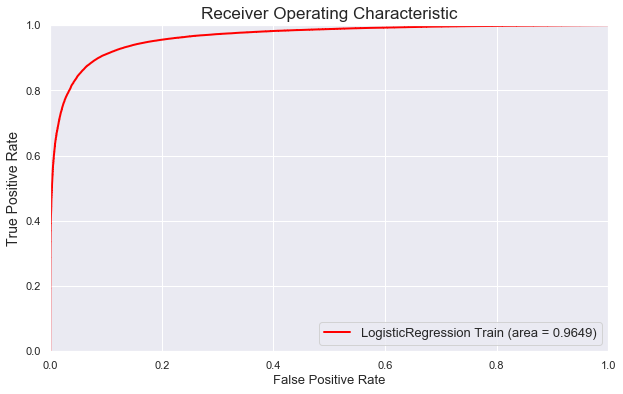

In [130]:
plt.figure(figsize=(10,6))

y_pred = logit.predict_proba(x_train_res)[:,1]
fpr, tpr, thresholds = roc_curve(y_train_res, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

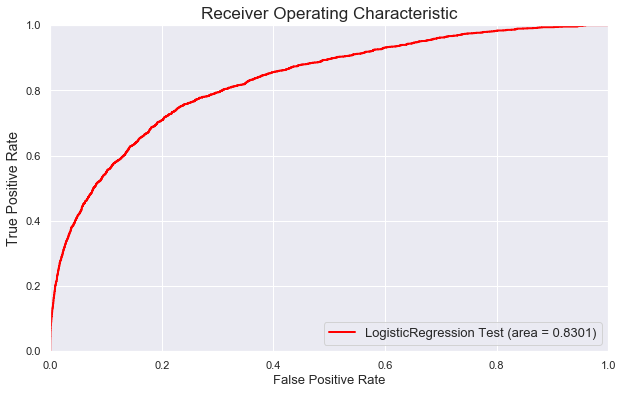

In [131]:
plt.figure(figsize=(10,6))

y_pred = logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

## Decision Tree

### Building a model

In [120]:
from sklearn.tree import DecisionTreeClassifier


In [121]:
dt = DecisionTreeClassifier(max_depth=8, random_state=42, class_weight={1:2})
dt.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={1: 2}, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [132]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=10,
                            n_estimators=100,
                            max_depth=8, 
                            random_state=42)

In [133]:
rf.fit(x_train_res, y_train_res)

RandomForestClassifier(max_depth=8, min_samples_leaf=10, random_state=42)

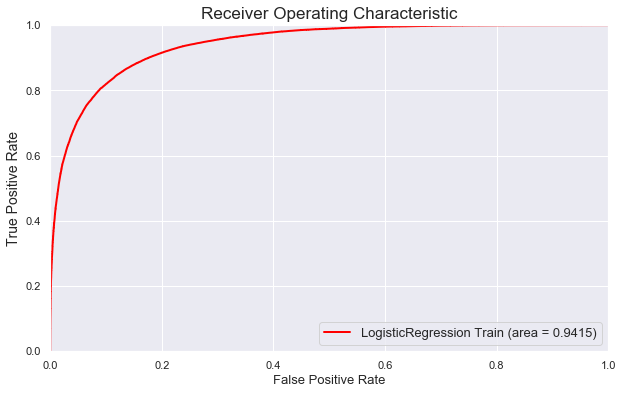

In [134]:
plt.figure(figsize=(10,6))

y_pred = rf.predict_proba(x_train_res)[:,1]
fpr, tpr, thresholds = roc_curve(y_train_res, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

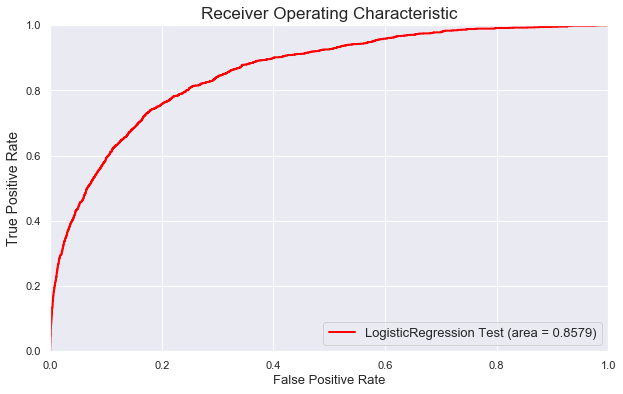

In [135]:
plt.figure(figsize=(10,6))

y_pred = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [136]:
from sklearn.ensemble import GradientBoostingClassifier

In [141]:
model_GB = GradientBoostingClassifier(n_estimators=100,  validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01)
model_GB

GradientBoostingClassifier(n_iter_no_change=5, tol=0.01,
                           validation_fraction=0.2)

In [142]:
model_GB.fit(x_train_res , y_train_res)

GradientBoostingClassifier(n_iter_no_change=5, tol=0.01,
                           validation_fraction=0.2)

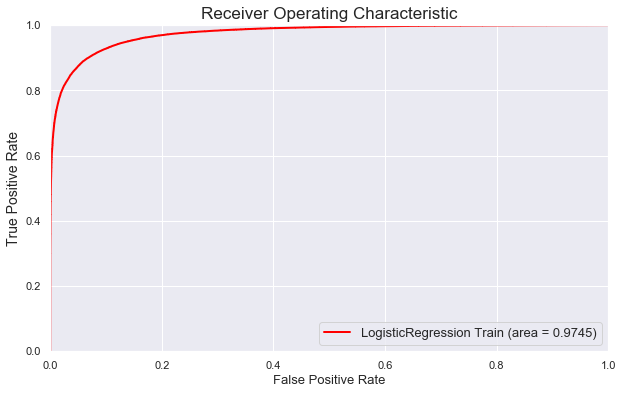

In [143]:
plt.figure(figsize=(10,6))

y_pred = model_GB.predict_proba(x_train_res)[:,1]
fpr, tpr, thresholds = roc_curve(y_train_res, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

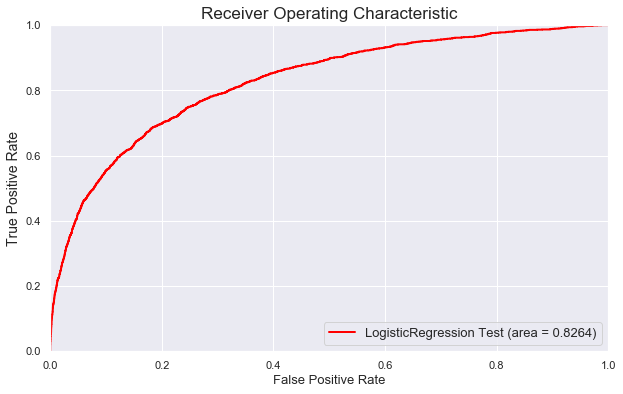

In [144]:
plt.figure(figsize=(10,6))

y_pred = model_GB.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [145]:
from sklearn.ensemble import AdaBoostClassifier
model_ad = AdaBoostClassifier()
model_ad.fit(x_train_res , y_train_res)

AdaBoostClassifier()

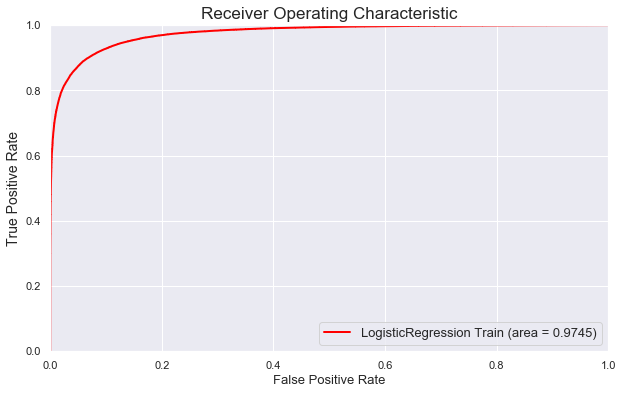

In [146]:
plt.figure(figsize=(10,6))

y_pred = model_ad.predict_proba(x_train_res)[:,1]
fpr, tpr, thresholds = roc_curve(y_train_res, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

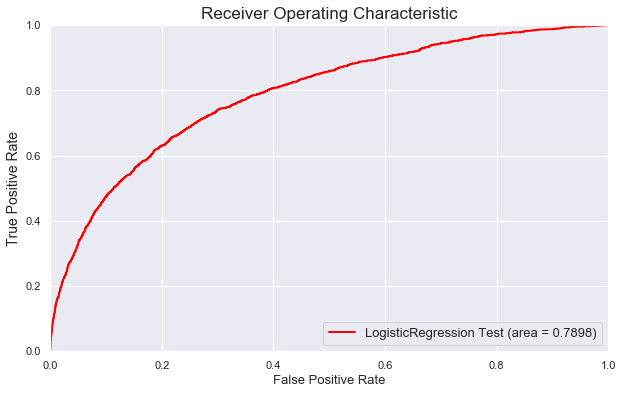

In [147]:
plt.figure(figsize=(10,6))

y_pred = model_ad.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [140]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# pprint(random_grid)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
